<a href="https://colab.research.google.com/github/TomokiArima/Simulation2024_Homework/blob/main/%E3%82%B7%E3%83%9F%E3%83%A5%E5%B7%A5_%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#スプレッドシートを操作するようにする認証のためのコード
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [15]:
#スプレッドシートのURLを入力
#url = input("スプレッドシートのURLを入力してください: ")
url = "https://docs.google.com/spreadsheets/d/1iFuzoZH7N4eCCIkV5xBRZogtyUlwnyOYrXnXWJjjrMk/edit?gid=2608365#gid=2608365"  #@@@@デバック用、url入力を省く

try:
  sh = gc.open_by_url(url)
  print(f"スプレッドシート '{sh.title}' が正常に開かれました。")

  #スプレッドシートの最初のシートを取得
  worksheet = sh.sheet1

  start_row = input("開始行番号")  #得るセル範囲の開始行を入力
  end_row = input("終了行番号")  #終了行を入力
  cell_range = f"B{start_row}:B{end_row}" #得るセル範囲を文字列にする(B20:B60みたいなやつ)

  cell_values = worksheet.range(cell_range) #{シートを取得した奴}.range(セル範囲)でセルを含むリストを得る

  #セルオブジェクトの中から値のみをfloat型として抽出して配列に変換(.range()だけでは値以外に行・列など余計な情報を含んでいるので)
  V_call = [] #とりあえず空のリストを作る
  for i in cell_values: #ループで cell_value から値をとりだす
    try:
      V_call.append(float(i.value)) #{インデックス}.valueでi番目の要素を文字列で取り出す。それをfloat型に変換してV_callという配列に追加
    except ValueError:
      print(f"エラーが発生しました、範囲に空白や文字列が含まれているかも: {e}")

  # 配列を表示
  print(f"取得したデータ (B列 {start_row}行から{end_row}行):")
  print(V_call)
  print("配列の長さは",len(V_call))

except gspread.exceptions.SpreadsheetNotFound:
  print("指定されたURLのスプレッドシートは見つかりませんでした。")
except Exception as e:
  print(f"エラーが発生しました: {e}")

スプレッドシート 'solid (1).CSV' が正常に開かれました。
開始行番号120
終了行番号420
取得したデータ (B列 120行から420行):
[6.32, 5.76, 4.8, 3.52, 2.08, 0.56, -0.96, -2.24, -3.44, -4.32, -4.72, -4.96, -4.72, -4.16, -3.28, -2.16, -0.8, 0.48, 1.76, 3.04, 4.16, 4.8, 5.2, 5.12, 4.64, 3.84, 2.88, 1.52, 0.32, -0.8, -2.0, -2.96, -3.68, -4.08, -4.16, -4.0, -3.44, -2.64, -1.84, -0.72, 0.48, 1.52, 2.48, 3.36, 4.0, 4.24, 4.24, 3.84, 3.2, 2.32, 1.2, 0.24, -0.8, -1.84, -2.56, -3.12, -3.44, -3.52, -3.28, -2.88, -2.24, -1.52, -0.48, 0.48, 1.44, 2.16, 2.96, 3.36, 3.6, 3.52, 3.2, 2.64, 1.84, 1.04, 0.16, -0.72, -1.6, -2.24, -2.64, -2.88, -2.96, -2.8, -2.32, -1.84, -1.12, -0.32, 0.48, 1.2, 2.0, 2.48, 2.88, 2.96, 2.96, 2.64, 2.08, 1.44, 0.8, 0.0, -0.72, -1.36, -1.92, -2.32, -2.48, -2.48, -2.32, -1.92, -1.52, -0.8, -0.16, 0.56, 1.2, 1.76, 2.16, 2.4, 2.48, 2.4, 2.16, 1.68, 1.12, 0.48, -0.16, -0.72, -1.28, -1.68, -2.0, -2.16, -2.16, -1.92, -1.6, -1.04, -0.48, 0.0, 0.56, 1.12, 1.68, 2.0, 2.08, 2.16, 2.0, 1.76, 1.36, 0.8, 0.24, -0.32, -0.8, -1.28, -1.6

In [16]:
#初期変位x0 自動調整

import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from IPython.display import display,clear_output

#減衰の式
def DampedOscillation (w0,k,x0,wd, t):
  x = [] #結果を格納するリストを初期化
  for ti in t: #tの各要素に対してループ、tiはi番目の配列の中身
    xi = x0 * (math.exp(-k * ti)) *(math.cos(wd * ti) + ((k/wd) * math.sin(wd * ti)))
    x.append(xi) # 結果をリストに追加
  return np.array(x) #リストをNumPy配列に変換して返す


#条件
t_max = len(V_call)*0.01 #時間範囲をV_callと同じ長さにする(配列の長さを揃える)
t = np.arange(0, t_max, 0.01)  #時間範囲(配列の長さをV_callと揃える)
x0 = V_call[0]  #初期変位x0
Va = None
Vb = None

w0a = np.arange(10,40,0.05)  #w0：固有角振動数 (実験～w0aは10～40の間に来ると想定している)
ka = np.arange(0,1.0,0.01) #k：減衰係数
w0b = np.arange(10,40,0.05)  #w0：固有角振動数
kb = np.arange(0,1.0,0.01)

mse_min = 100

for w0a_i in w0a: #w0aを走査
  for ka_j in ka: #kaを走査
    try:
      Va = None #Vaの中身をリセット
      wda = math.sqrt((w0a_i**2) - (ka_j**2))  #wd：角振動数(減衰有)
      Va = DampedOscillation(w0a_i,ka_j,x0,wda,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

    except ValueError:
            print("Error: wd=√(ω₀a² - ka²)が負になった可能性")

  #二乗平均誤差が最小のものを探し出す
    mse_new = np.mean((Va - V_call) ** 2) #二乗平均誤差を計算(Mean Squared Error (MSE))
    if mse_new < mse_min:
      mse_min = mse_new #mse_minを更新
      best_w0a = w0a_i  #最小の時のiを記録
      best_ka = ka_j  #最小の時のjを記録
      best_Va = Va #最小の時のVを記録

print("最小二乗平均誤差",mse_min,"その時のi",best_w0a,"  その時のj",best_ka)

#best_Vaを表示
plt.plot(t, best_Va)
plt.xlabel('t')
plt.ylabel('best_Va')
plt.grid(True)
plt.show()
#V_callを表示
plt.plot(t, V_call)
plt.xlabel('t')
plt.ylabel('V_call')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

最小二乗平均誤差 0.14602762382106083 その時のi 27.70000000000025   その時のj 0.92


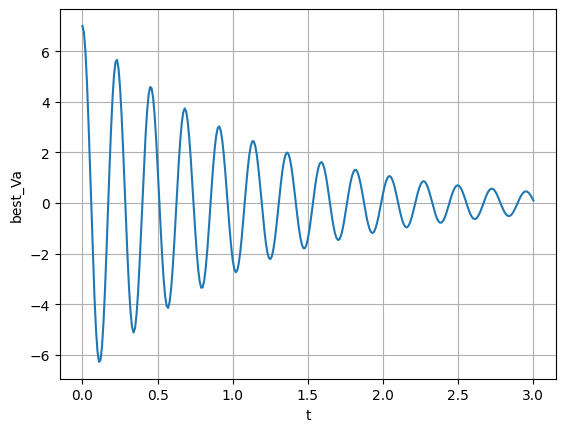

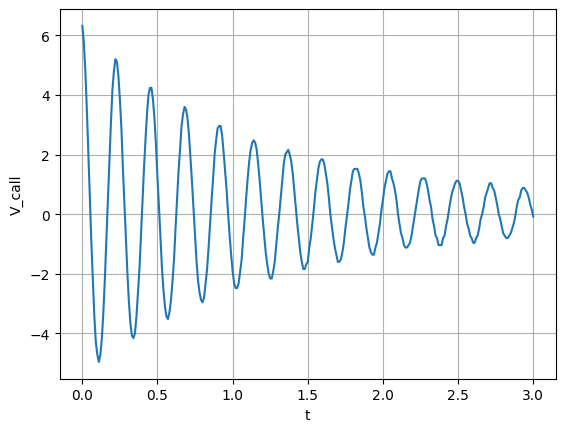

In [17]:
#初期変位x0 = 7.00

import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from IPython.display import display,clear_output

#減衰の式
def DampedOscillation (w0,k,x0,wd, t):
  x = [] #結果を格納するリストを初期化
  for ti in t: #tの各要素に対してループ、tiはi番目の配列の中身
    xi = x0 * (math.exp(-k * ti)) *(math.cos(wd * ti) + ((k/wd) * math.sin(wd * ti)))
    x.append(xi) # 結果をリストに追加
  return np.array(x) #リストをNumPy配列に変換して返す


#条件
t_max = len(V_call)*0.01 #時間範囲をV_callと同じ長さにする(配列の長さを揃える)
t = np.arange(0, t_max, 0.01)  #時間範囲(配列の長さをV_callと揃える)
x0 = 7  #初期変位x0
Va = None
Vb = None

w0a = np.arange(10,40,0.05)  #w0：固有角振動数 (実験～w0aは10～40の間に来ると想定している)
ka = np.arange(0,1.0,0.01) #k：減衰係数
w0b = np.arange(10,40,0.05)  #w0：固有角振動数
kb = np.arange(0,1.0,0.01)

mse_min = 100

for w0a_i in w0a: #w0aを走査
  for ka_j in ka: #kaを走査
    try:
      Va = None #Vaの中身をリセット
      wda = math.sqrt((w0a_i**2) - (ka_j**2))  #wd：角振動数(減衰有)
      Va = DampedOscillation(w0a_i,ka_j,x0,wda,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

    except ValueError:
            print("Error: wd=√(ω₀a² - ka²)が負になった可能性")

  #二乗平均誤差が最小のものを探し出す
    mse_new = np.mean((Va - V_call) ** 2) #二乗平均誤差を計算(Mean Squared Error (MSE))
    if mse_new < mse_min:
      mse_min = mse_new #mse_minを更新
      best_w0a = w0a_i  #最小の時のiを記録
      best_ka = ka_j  #最小の時のjを記録
      best_Va = Va #最小の時のVを記録

print("最小二乗平均誤差",mse_min,"その時のi",best_w0a,"  その時のj",best_ka)

#best_Vaを表示
plt.plot(t, best_Va)
plt.xlabel('t')
plt.ylabel('best_Va')
plt.grid(True)
plt.show()
#V_callを表示
plt.plot(t, V_call)
plt.xlabel('t')
plt.ylabel('V_call')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from IPython.display import display,clear_output

#減衰の式
def DampedOscillation (w0,k,x0,wd, t):
  x = [] #結果を格納するリストを初期化
  for ti in t: #tの各要素に対してループ、tiはi番目の配列の中身
    xi = x0 * (math.exp(-k * ti)) *(math.cos(wd * ti) + ((k/wd) * math.sin(wd * ti)))
    x.append(xi) # 結果をリストに追加
  return np.array(x) #リストをNumPy配列に変換して返す


#条件
t = np.arange(0, 10, 0.01)  #時間範囲
x0 = 7  #初期変位x0
Va = None
Vb = None

#スライダーの設定
w0a_slider = widgets.FloatSlider(value=5, min=1, max=100, step=0.1, description='ω₀a:')  #w0：固有角振動数　(value=初期値、min,max=スライダー範囲、step=刻み幅、description=スライダータイトル)
ka_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01, description='ka:') #k：減衰係数
w0b_slider = widgets.FloatSlider(value=5, min=1, max=100, step=0.1, description='ω₀b:')  #w0：固有角振動数　(value=初期値、min,max=スライダー範囲、step=刻み幅、description=スライダータイトル)
kb_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01, description='kb:')

#グラフを出力する所を作成
output_a = widgets.Output()
output_b = widgets.Output()
output_c = widgets.Output()

#関数：スライダーの値が変更されたときの更新処理(a)
def update_plot_a(change):
  global Va  #Vをグローバル変数として扱う
  with output_a:  #グラフを出力する所のoutputを開く
    clear_output(True)   #以前の出力を削除する
    #スライダーの値をw0,kに代入する
    w0a = w0a_slider.value  #".value"でスライダーの値を取得する
    ka = ka_slider.value

    try:
      wda = math.sqrt((w0a**2) - (ka**2))  #wd：角振動数(減衰有)
      Va = DampedOscillation(w0a,ka,x0,wda,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

      plt.plot(t, Va)
      plt.xlabel('t')
      plt.ylabel('Va')
      plt.title(f'w0a = {w0a:.2f}, ka = {ka:.2f}, x₀a = {x0:.2f}')
      plt.grid(True) # グリッド表示
      plt.show()

      update_plot_sum() #update_plot_sumを呼び出す(値が変わったのでグラフを更新する)

    except ValueError:
            print("Error: wd=√(ω₀a² - ka²)が負になった可能性")

#関数：スライダーの値が変更されたときの更新処理(b)
def update_plot_b(change):
  global Vb  #Vをグローバル変数として扱う
  with output_b:  #グラフを出力する所のoutputを開く
    clear_output(True)   #以前の出力を削除する
    #スライダーの値をw0,kに代入する
    w0b = w0b_slider.value  #".value"でスライダーの値を取得する
    kb = kb_slider.value

    try:
      wdb = math.sqrt((w0b**2) - (kb**2))  #wd：角振動数(減衰有)
      Vb = DampedOscillation(w0b,kb,x0,wdb,t) #V：変位　減衰の式(DampedOscillation)に各値を代入して計算

      plt.plot(t, Vb)
      plt.xlabel('t')
      plt.ylabel('Vb')
      plt.title(f'w0b = {w0b:.2f}, kb = {kb:.2f}, x₀b = {x0:.2f}')
      plt.grid(True) # グリッド表示
      plt.show()

      update_plot_sum() #update_plot_sumを呼び出す(値が変わったのでグラフを更新する)

    except ValueError:
            print("Error: wd=√(ω₀b² - kb²)が負になった可能性")

#二つのグラフを足し合わせる関数
def update_plot_sum():
  with output_c:  #グラフを出力する所のoutputを開く
    clear_output(True)   #以前の出力を削除する

    Vsum = Va + Vb

    plt.plot(t, Vsum)
    plt.xlabel('t')
    plt.ylabel('Vsum')
    plt.title(f'Vsum = Va + Vb')
    plt.grid(True)
    plt.show()

#スライダーの値の変化を検知する
w0a_slider.observe(update_plot_a,names='value')  #names='value'でスライダーの値を検知する指定。　検知された際に呼び出す関数はupdate_plot_aもしくは_b
ka_slider.observe(update_plot_a, names='value')
w0b_slider.observe(update_plot_b, names='value')
kb_slider.observe(update_plot_b, names='value')

display(w0a_slider, ka_slider, output_a) #スライダーと出力エリアをNotebook上に表示
display(w0b_slider, kb_slider, output_b)
display(output_c,)


update_plot_a(None)
update_plot_b(None)
update_plot_sum()



FloatSlider(value=5.0, description='ω₀a:', min=1.0)

FloatSlider(value=0.1, description='ka:', max=1.0, min=0.01, step=0.01)

Output()

FloatSlider(value=5.0, description='ω₀b:', min=1.0)

FloatSlider(value=0.1, description='kb:', max=1.0, min=0.01, step=0.01)

Output()

Output()